# 正則化項による回帰

## ライブラリのインポート

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

## データセットのインポート

In [2]:
train_df = pd.read_csv('train.csv', dtype={1:str}, parse_dates=[1])
test_df = pd.read_csv('test.csv', dtype={1:str}, parse_dates=[1])

## データセットの前処理

In [3]:
train_df.head()

,row_id,date,country,store,product,num_sold
0,0,2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,663
1,1,2017-01-01,Belgium,KaggleMart,Kaggle Getting Started,615
2,2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480
3,3,2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710
4,4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240


In [4]:
test_df.head()

,row_id,date,country,store,product
0,70128,2021-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques
1,70129,2021-01-01,Belgium,KaggleMart,Kaggle Getting Started
2,70130,2021-01-01,Belgium,KaggleMart,Kaggle Recipe Book
3,70131,2021-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose
4,70132,2021-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques


In [5]:
print('学習データのデータ数:{}'.format(len(train_df)))
print('テストデータのデータ数:{}'.format(len(test_df)))

学習データのデータ数:70128
テストデータのデータ数:17520


In [6]:
train_df.describe()

,row_id,num_sold
count,70128.000000,70128.000000
mean,35063.500000,194.296986
std,20244.354176,126.893874
min,0.000000,19.000000
25%,17531.750000,95.000000
50%,35063.500000,148.000000
75%,52595.250000,283.000000
max,70127.000000,986.000000


In [7]:
train_df.columns

Index(['row_id', 'date', 'country', 'store', 'product', 'num_sold'], dtype='object')

In [8]:
test_df.columns

Index(['row_id', 'date', 'country', 'store', 'product'], dtype='object')

### 年、月、日のデータの抽出

In [9]:
train_df['date'].nunique()

1461

In [10]:
train_df['year'] = train_df['date'].dt.year
test_df['year'] = test_df['date'].dt.year
train_df['month'] = train_df['date'].dt.month
test_df['month'] = test_df['date'].dt.month
train_df['day'] = train_df['date'].dt.day
test_df['day'] = test_df['date'].dt.day

In [12]:
train_df = train_df.drop('date', axis=1)
test_df = test_df.drop('date', axis=1)

In [13]:
train_df.head()

,row_id,country,store,product,num_sold,year,month,day
0,0,Belgium,KaggleMart,Kaggle Advanced Techniques,663,2017,1,1
1,1,Belgium,KaggleMart,Kaggle Getting Started,615,2017,1,1
2,2,Belgium,KaggleMart,Kaggle Recipe Book,480,2017,1,1
3,3,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710,2017,1,1
4,4,Belgium,KaggleRama,Kaggle Advanced Techniques,240,2017,1,1


### 特徴量と目的変数

In [14]:
y_col = 'num_sold'
X = train_df.loc[:, train_df.columns!=y_col]
y = train_df[y_col]

In [15]:
# 数値カラムの取得
numeric_cols = X.select_dtypes(include=np.number).columns.to_list()

### one-hot-encoding

In [16]:
X['country'].unique()

array(['Belgium', 'France', 'Germany', 'Italy', 'Poland', 'Spain'],
      dtype=object)

In [17]:
X['store'].unique()

array(['KaggleMart', 'KaggleRama'], dtype=object)

In [18]:
X['product'].unique()

array(['Kaggle Advanced Techniques', 'Kaggle Getting Started',
       'Kaggle Recipe Book', 'Kaggle for Kids: One Smart Goose'],
      dtype=object)

In [19]:
X = pd.get_dummies(X, drop_first=True)
test_df = pd.get_dummies(test_df, drop_first=True)

In [20]:
X = X.drop('row_id', axis=1)
index_test_df = test_df['row_id']
test_df = test_df.drop('row_id', axis=1)

## 最適なLasso

In [21]:
k = 5
n_repeats = 3
cv = RepeatedKFold(n_splits=k, n_repeats=n_repeats, random_state=0)
alphas = np.logspace(-2, 5)
smape_list = []
for alpha in alphas:
    pipeline = Pipeline(steps=[('scaler', StandardScaler()), ('ridge', Ridge(alpha))])
    smape_list.append(cross_val_score(pipeline, X, y, scoring='neg_mean_absolute_percentage_error', cv=cv).mean())

In [22]:
smape_list = [-1 * smape for smape in smape_list] 

Text(0, 0.5, 'test SMAPE')

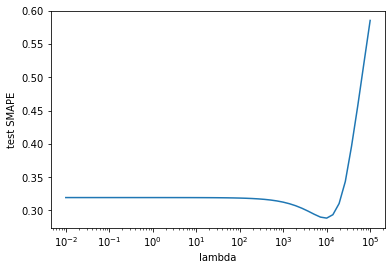

In [23]:
plt.plot(alphas, smape_list)
plt.xscale('log')
plt.xlabel('lambda')
plt.ylabel('test SMAPE')

## モデルの学習

In [24]:
pipeline = Pipeline(steps=[('scaler', StandardScaler()), ('ridge', Ridge(alphas[np.argmin(smape_list)]))])
scores = cross_val_score(pipeline, X, y, scoring='neg_mean_absolute_percentage_error', cv=cv)
scores

array([-0.28893114, -0.28913946, -0.28733946, -0.28897009, -0.28742602,
       -0.2892825 , -0.28894989, -0.28675127, -0.28999005, -0.28685668,
       -0.28983458, -0.28881952, -0.28715602, -0.28594987, -0.29017316])

In [25]:
pipeline.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()), ('ridge', Ridge(alpha=10000.0))])

## テストデータに対する予測

In [26]:
X_test = test_df.values

In [27]:
y_pred = pipeline.predict(X_test)

/Users/atsus/opt/anaconda3/envs/py3-TF2.0/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


In [28]:
y_pred

array([345.95765006, 313.75519455, 273.19838516, ..., 108.82685991,
        68.27005051, 164.89559799])

In [29]:
data = {
    'row_id': index_test_df,
    'num_sold': y_pred
}
sub = pd.DataFrame(data)

In [30]:
sub.head()

,row_id,num_sold
0,70128,345.957650
1,70129,313.755195
2,70130,273.198385
3,70131,369.823933
4,70132,181.000357
